In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm 

In [22]:
dataframe_final = pd.read_parquet('dados_webscraping/dataframe_imoveis_venda_pronto_para_predicao_v2.parquet')

print(dataframe_final.shape)
display(dataframe_final.head(2))
print("Porcentagem de informações faltantes: ")
display(round(dataframe_final.isna().sum()/dataframe_final.shape[0] * 100, 2).astype(str) + " %")


(1139, 26)


,url,endereco,preco,area,quartos,vagas_de_carro,mobiliado,piscina,condominio,elevador,jardim,quadra_esportiva,academia,finalidade,tipo,localizacao,latitude,longitude,geometry,nome,distancia_metro,distancia_unidade_saude,indic_rend,indic_lixo,indic_agua,preco_log
7,https://www.zapimoveis.com.br/imovel/venda-apa...,"Rua Barão, 450 - Praça Seca, Rio de Janeiro - RJ",195000.0,56.0,2.0,1,False,True,True,True,True,True,True,residencial,apartamento,"Rua Barão, Praça Seca, Rio de Janeiro, Região ...",-22.89567935,-43.35641545,b'\x01\x01\x00\x00\x00C\xc8~\x05\x9f\xadE\xc0\...,Praça Seca,10138.418568,1850.721339,3.681449,99.660238,98.861081,12.180760
8,https://www.zapimoveis.com.br/imovel/venda-apa...,"Avenida dos Mananciais, 534 - Taquara, Rio de ...",400000.0,66.0,3.0,1,False,True,True,False,False,False,True,residencial,apartamento,"Avenida dos Mananciais, Boiúna, Taquara, Rio d...",-22.917881299999998,-43.395858700000005,b'\x01\x01\x00\x00\x00n.u\x7f\xab\xb2E\xc0\x0c...,Taquara,16915.620046,2813.306033,4.134871,99.837475,99.326261,12.899222


Porcentagem de informações faltantes: 


url                        0.0 %
endereco                   0.0 %
preco                      0.0 %
area                       0.0 %
quartos                    0.0 %
vagas_de_carro             0.0 %
mobiliado                  0.0 %
piscina                    0.0 %
condominio                 0.0 %
elevador                   0.0 %
jardim                     0.0 %
quadra_esportiva           0.0 %
academia                   0.0 %
finalidade                 0.0 %
tipo                       0.0 %
localizacao                0.0 %
latitude                   0.0 %
longitude                  0.0 %
geometry                   0.0 %
nome                       0.0 %
distancia_metro            0.0 %
distancia_unidade_saude    0.0 %
indic_rend                 0.0 %
indic_lixo                 0.0 %
indic_agua                 0.0 %
preco_log                  0.0 %
dtype: object

In [24]:
colunas_analise = ['preco', 'area', 'quartos', 'vagas_de_carro', 
                   "mobiliado", "tipo", "distancia_metro", 'distancia_unidade_saude',
                   'indic_rend', 'indic_lixo', 'indic_agua']

display(dataframe_final[colunas_analise].info())

X = dataframe_final[colunas_analise].drop('preco', axis=1)  # Remover a coluna 'preco' de X
y = dataframe_final['preco']

<class 'pandas.core.frame.DataFrame'>
Index: 1139 entries, 7 to 3859
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   preco                    1139 non-null   float64
 1   area                     1139 non-null   float64
 2   quartos                  1139 non-null   float64
 3   vagas_de_carro           1139 non-null   int64  
 4   mobiliado                1139 non-null   bool   
 5   tipo                     1139 non-null   object 
 6   distancia_metro          1139 non-null   float64
 7   distancia_unidade_saude  1139 non-null   float64
 8   indic_rend               1139 non-null   float64
 9   indic_lixo               1139 non-null   float64
 10  indic_agua               1139 non-null   float64
dtypes: bool(1), float64(8), int64(1), object(1)
memory usage: 99.0+ KB


None

In [25]:
# Separar colunas numéricas, categóricas e booleanas
colunas_numericas = X.select_dtypes(include=[np.number]).columns.tolist()
colunas_categoricas = X.select_dtypes(include=[object]).columns.tolist()
colunas_booleanas = X.select_dtypes(include=[bool]).columns.tolist()

# Criar o pré-processador com StandardScaler para colunas numéricas e OneHotEncoder para colunas categóricas e booleanas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), colunas_categoricas + colunas_booleanas)
    ])

# Aplicar o pré-processador nos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.fit_transform(X_test)

In [26]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=preprocessor.get_feature_names_out())
pd.set_option('display.max_columns', None)
print(X_train_scaled_df.shape)
display(X_train_scaled_df.head(2))

(911, 12)


,num__area,num__quartos,num__vagas_de_carro,num__distancia_metro,num__distancia_unidade_saude,num__indic_rend,num__indic_lixo,num__indic_agua,cat__tipo_apartamento,cat__tipo_casa,cat__mobiliado_False,cat__mobiliado_True
0,1.212384,0.911176,0.0,1.511739,2.63116,-0.50613,-1.642497,-1.972490,1.0,0.0,1.0,0.0
1,-0.732407,-0.598063,0.0,-0.717427,-1.05890,0.63045,0.773204,0.748429,1.0,0.0,1.0,0.0


In [6]:
parametros = {
    "Linear Regression": {},  # Sem hiperparâmetros para ajustar
    "Ridge Regression": {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    "Random Forest": {
        'model__n_estimators': [50, 100, 200, 300],
        'model__max_depth': [5, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    "Gradient Boosting": {
        'model__n_estimators': [50, 100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__subsample': [0.8, 0.9, 1.0]
    }
}

modelos = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False),
    'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'R²': make_scorer(r2_score)
}

In [27]:
lista_com_resultados = []
resultados_modelos = {}

print("Treinando modelos com ajuste de hiperparâmetros...\n")

for nome, modelo in tqdm(modelos.items(), desc="Modelos treinados"):
    # Criar o pipeline
    pipeline = Pipeline([
        #('preprocessor', preprocessor),  # Pré-processador
        ('model', modelo)              # Modelo
    ])
    
    # Configurar o GridSearchCV (caso haja hiperparâmetros para ajustar)
    if parametros[nome]:  # Apenas modelos com hiperparâmetros definidos
        grid_search = GridSearchCV(
            pipeline, 
            param_grid=parametros[nome], 
            cv=5, 
            scoring={"MAE":"neg_mean_absolute_error",
                     "RMSE":"neg_root_mean_squared_error",
                     "MAPE": "neg_mean_absolute_percentage_error",
                     "R²":"r2"},  # Métrica principal
            refit="MAE",
            n_jobs=-1, 
            return_train_score=True
        )
        # Treinar o modelo
        grid_search.fit(X_train_scaled, y_train)
        lista_com_resultados.append({f"{modelo}" : grid_search.cv_results_})
                
        # Melhor modelo e desempenho
        melhor_modelo = grid_search.best_estimator_
        melhor_params = grid_search.best_params_
        melhor_mae = -grid_search.best_score_  # Negativo porque usamos 'neg_mean_absolute_error'
    else:
        # Para modelos sem hiperparâmetros (como Linear Regression)
        pipeline.fit(X_train_scaled, y_train)
        melhor_modelo = pipeline
        melhor_params = "Sem ajuste de hiperparâmetros"
        melhor_mae = "Não aplicável"
    
    # Executar validação cruzada com o melhor modelo
    resultados_cv = cross_validate(
        melhor_modelo, X_train_scaled, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1
    )
    
    # Armazenar os resultados
    resultados_modelos[nome] = {
        'Melhores Parâmetros': melhor_params,
        'Melhor Modelo': melhor_modelo,
        'MAE': -resultados_cv.get('test_MAE', np.array(0)).mean(),
        'MAPE': -resultados_cv.get('test_MAPE', np.array(0)).mean(),
        'RMSE': -resultados_cv.get('test_RMSE', np.array(0)).mean(),
        'R²': resultados_cv.get('test_R²', np.array(0)).mean()
    }

Treinando modelos com ajuste de hiperparâmetros...



Modelos treinados:  50%|█████     | 2/4 [00:17<00:16,  8.17s/it]c:\Users\FVF0\OneDrive - PETROBRAS\Dev\zap-imoveis-scraping-prediction\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
Modelos treinados:  75%|███████▌  | 3/4 [01:27<00:36, 36.44s/it]c:\Users\FVF0\OneDrive - PETROBRAS\Dev\zap-imoveis-scraping-prediction\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
Modelos treinados: 100%|██████████| 4/4 [02:11<00:00, 32.79s/it]


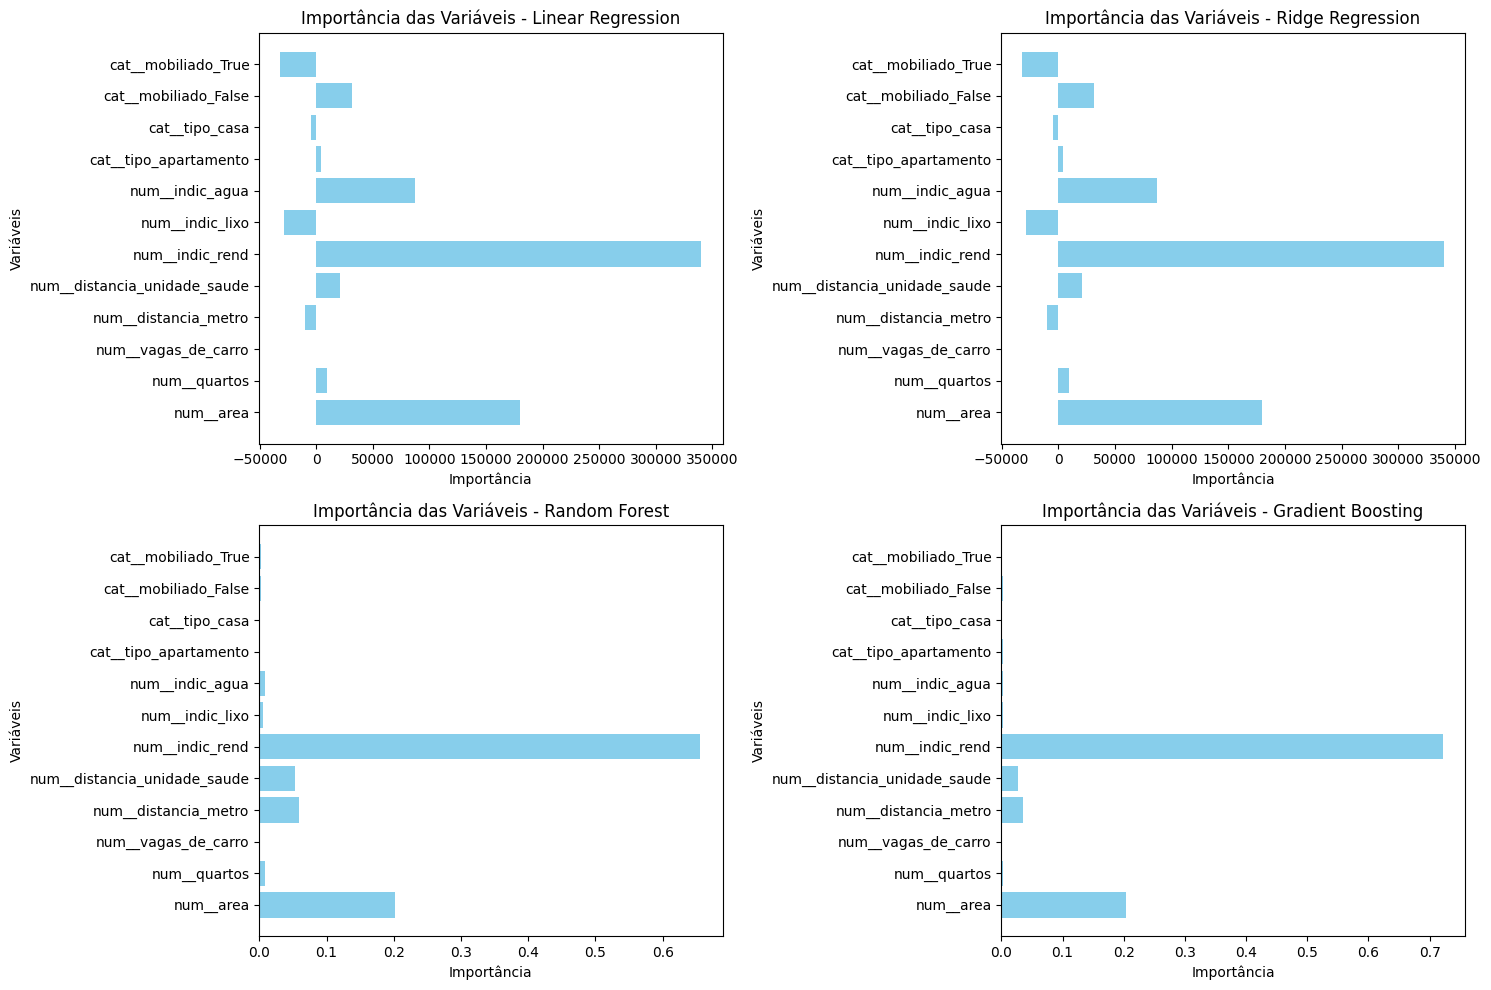

In [28]:
# Inicializar lista para armazenar importâncias
importancias_comparadas = pd.DataFrame()

# Definir o número de subgráficos
num_modelos = len(modelos)
num_colunas = 2  # 2 colunas
num_linhas = (num_modelos + 1) // num_colunas  # Calculando as linhas para acomodar os subgráficos

# Criar a figura e os subgráficos
plt.figure(figsize=(15, 5 * num_linhas))

for i, (nome, modelo) in enumerate(modelos.items()):
    plt.subplot(num_linhas, num_colunas, i + 1)
    
    modelo_treinado = modelo.fit(X_train_scaled_df, y_train)
    
    if nome in ["Linear Regression", "Ridge Regression"]:
        importancias = modelo_treinado.coef_
    elif nome in ["Random Forest", "Gradient Boosting"]:
        importancias = modelo_treinado.feature_importances_
    else:
        resultado_permutation = permutation_importance(
            modelo_treinado, X_train_scaled_df, y_train, n_repeats=10, random_state=42
        )
        importancias = resultado_permutation.importances_mean

    # Verificar alinhamento das dimensões
    if len(importancias) != len(X_train_scaled_df.columns):
        raise ValueError(
            f"Modelo {nome}: número de importâncias ({len(importancias)}) "
            f"diferente do número de colunas em X ({len(X_train_scaled_df.columns)})."
        )
    
    # Plotar a importância das variáveis
    plt.barh(X_train_scaled_df.columns, importancias, color='skyblue')
    plt.title(f'Importância das Variáveis - {nome}')
    plt.xlabel('Importância')
    plt.ylabel('Variáveis')

plt.tight_layout()
plt.show()

In [29]:
# Exibir os resultados
print("Resultados da validação cruzada com ajuste de hiperparâmetros:\n")
for nome, metricas in resultados_modelos.items():
    print(f"Modelo: {nome}")
    print(f"  Melhores Parâmetros: {metricas['Melhores Parâmetros']}")
    print(f"  MAE: {metricas['MAE']:.4f}")
    print(f"  MAPE: {metricas['MAPE']:.4f}")
    print(f"  RMSE: {metricas['RMSE']:.4f}")
    print(f"  R²: {metricas['R²']:.4f}\n")


# Resultados da validação cruzada com ajuste de hiperparâmetros:

# Modelo: Linear Regression
#   Melhores Parâmetros: Sem ajuste de hiperparâmetros
#   MAE: 203951.8620
#   RMSE: 279206.0217
#   R²: 0.7001

# Modelo: Ridge Regression
#   Melhores Parâmetros: {'model__alpha': 100.0}
#   MAE: 202109.9878
#   RMSE: 284986.7170
#   R²: 0.6905

# Modelo: Random Forest
#   Melhores Parâmetros: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
#   MAE: 156187.9344
#   RMSE: 238708.3449
#   R²: 0.7792

# Modelo: Gradient Boosting
#   Melhores Parâmetros: {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 300, 'model__subsample': 0.8}
#   MAE: 155864.5529
#   RMSE: 234146.5369
#   R²: 0.7871



Resultados da validação cruzada com ajuste de hiperparâmetros:

Modelo: Linear Regression
  Melhores Parâmetros: Sem ajuste de hiperparâmetros
  MAE: 205152.9506
  MAPE: 36.1672
  RMSE: 280929.0404
  R²: 0.7192

Modelo: Ridge Regression
  Melhores Parâmetros: {'model__alpha': 100.0}
  MAE: 201687.7551
  MAPE: 34.0491
  RMSE: 284019.3413
  R²: 0.7139

Modelo: Random Forest
  Melhores Parâmetros: {'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 300}
  MAE: 155543.3098
  MAPE: 22.3457
  RMSE: 243088.8669
  R²: 0.7892

Modelo: Gradient Boosting
  Melhores Parâmetros: {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 100, 'model__subsample': 0.9}
  MAE: 156044.9028
  MAPE: 22.6257
  RMSE: 241979.2548
  R²: 0.7914



In [30]:
print("\nAvaliando modelos no conjunto de teste...\n")

resultados_teste = {}

for nome, modelo_info in resultados_modelos.items():
    
    melhor_modelo = modelo_info['Melhor Modelo']    
    y_pred = melhor_modelo.predict(X_test_scaled)
    
    # Calcular métricas no conjunto de teste
    mae_teste = mean_absolute_error(y_test, y_pred)
    rmse_teste = mean_squared_error(y_test, y_pred)
    mape_teste = mean_absolute_percentage_error(y_test, y_pred)
    r2_teste = r2_score(y_test, y_pred)
    
    # Armazenar resultados de teste separadamente
    resultados_teste[nome] = {
        'MAE_Teste': mae_teste,
        'RMSE_Teste': rmse_teste,
        'MAPE_Teste': mape_teste,
        'R²_Teste': r2_teste
    }

# Exibir resultados no console
for nome, metrics in resultados_teste.items():
    print(f"\nModelo: {nome}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


Avaliando modelos no conjunto de teste...


Modelo: Linear Regression
  MAE_Teste: 215463.9954
  RMSE_Teste: 92864334730.0572
  MAPE_Teste: 32.2279
  R²_Teste: 0.7395

Modelo: Ridge Regression
  MAE_Teste: 216431.6163
  RMSE_Teste: 99549654617.0547
  MAPE_Teste: 30.8603
  R²_Teste: 0.7207

Modelo: Random Forest
  MAE_Teste: 175443.3907
  RMSE_Teste: 70547812007.0762
  MAPE_Teste: 22.1230
  R²_Teste: 0.8021

Modelo: Gradient Boosting
  MAE_Teste: 176748.0239
  RMSE_Teste: 78268606762.9650
  MAPE_Teste: 22.2597
  R²_Teste: 0.7804


c:\Users\FVF0\OneDrive - PETROBRAS\Dev\zap-imoveis-scraping-prediction\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# Melhorando o modelo

In [31]:
# Dicionário para armazenar os resultados agrupados
resultados_agrupados = {}

# Iterar pelos dicionários na lista
for dicionario in lista_com_resultados:
    for algoritmo, metrica_dados in dicionario.items():
        # Inicializa o algoritmo no dicionário se não existir
        if algoritmo not in resultados_agrupados:
            resultados_agrupados[algoritmo] = {"MAE": [], "RMSE": [], "R²": [], "MAPE": []}

        # Processa cada métrica e valor
        for metrica, valor in metrica_dados.items():
            if "test" in metrica:
                if "MAE" in metrica:
                    resultados_agrupados[algoritmo]["MAE"].append(valor)
                elif "RMSE" in metrica:
                    resultados_agrupados[algoritmo]["RMSE"].append(valor)
                elif "R²" in metrica:
                    resultados_agrupados[algoritmo]["R²"].append(valor)
                elif "MAPE" in metrica:
                    resultados_agrupados[algoritmo]["MAPE"].append(valor)


lista_de_dataframes = []
dataframe_original = pd.DataFrame(resultados_agrupados)

for coluna in dataframe_original.columns:

    df_exploded = dataframe_original[coluna].explode()
    
    df_melted = pd.DataFrame({
        'Métrica': df_exploded.index,
        'Valor': df_exploded.values
    })
    
    # Adicionar o nome do algoritmo extraído da coluna
    df_melted["Algoritmo"] = re.sub(r'\(.*?\)', '', coluna)
    lista_de_dataframes.append(df_melted)

# Concatenar todos os DataFrames da lista em um único DataFrame final
dataframe_final = pd.concat(lista_de_dataframes, ignore_index=True)
dataframe_final = dataframe_final.explode("Valor").reset_index(drop=True)
dataframe_final = dataframe_final[dataframe_final['Valor'] % 1 != 0]
display(dataframe_final)


,Métrica,Valor,Algoritmo
0,MAE,-193911.432694,Ridge
1,MAE,-193898.604516,Ridge
2,MAE,-193770.934155,Ridge
3,MAE,-192556.577415,Ridge
4,MAE,-186006.145031,Ridge
...,...,...,...
9227,MAPE,0.0054,GradientBoostingRegressor
9228,MAPE,0.010477,GradientBoostingRegressor
9229,MAPE,0.011667,GradientBoostingRegressor
9230,MAPE,0.006083,GradientBoostingRegressor


In [18]:
dataframe_final.to_csv('data/resultados_dos_modelos_venda.csv', index=False)